In [11]:
import dolphindb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def draw(result):
    fig, axs = plt.subplots(4, figsize=(10, 10))
    result.set_index("trade_time").groupby('grp')['af_rev'].plot(legend=True, ax=axs[0])
    result.set_index("trade_time").groupby('grp')['cumret'].plot(legend=True, ax=axs[1])
    result.set_index("trade_time").groupby('grp')['cumfee'].plot(legend=True, ax=axs[2])
    result.set_index("trade_time").groupby('grp')['cnt'].plot(legend=True, ax=axs[3])
    
def cal_sharpe(ret: pd.Series):
    single_ret = ret.diff().dropna()
    sharpe = single_ret.mean() / single_ret.std() * np.sqrt(365*3)
    return sharpe

def backtest(factor, num = 2):
    def core(num):
        sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
        sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
        sess.run("tableInsert{factor}",factor.dropna())
        # sess.upload({
        #     'factor': factor,
        #     'num': num
        # })
        sess.upload({'num': num})
        try:
            df: pd.DataFrame = sess.runFile("backtest.dos")
        except Exception as e:
            error_msg = str(e).split('script:')[0]
            print(error_msg)
            raise e
        sess.run('clearAllCache()')
        sess.close()
        return df
    
    df = core(num)    
    return df

                 trade_time instrument  factor_value
338872  2021-01-01 00:00:00  1INCHUSDT      0.012227
338873  2021-01-01 00:00:00   AAVEUSDT      0.011502
338874  2021-01-01 00:00:00    ADAUSDT     -0.001980
338875  2021-01-01 00:00:00   ALGOUSDT     -0.007591
338876  2021-01-01 00:00:00  ALPHAUSDT      0.006095
...                     ...        ...           ...
4556433 2024-02-24 11:00:00    ZECUSDT     -0.004093
4556434 2024-02-24 11:00:00    ZENUSDT     -0.003406
4556435 2024-02-24 11:00:00   ZETAUSDT     -0.002366
4556436 2024-02-24 11:00:00    ZILUSDT     -0.007042
4556437 2024-02-24 11:00:00    ZRXUSDT     -0.009150

[4217566 rows x 3 columns]
2.5942729912105924


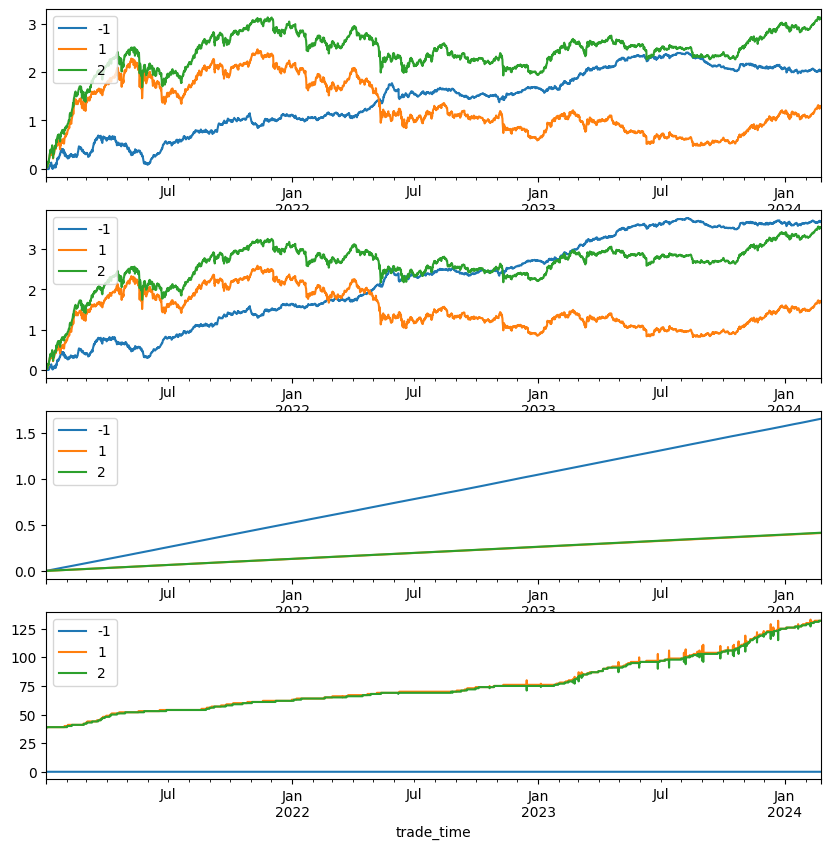

In [16]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df = sess.runFile('factors/factor1.dos')
df = df[df['trade_time'] >= '20210101']
print(df)
# df['factor_value'] = -df['factor_value']
# print(df)
sess.close()
result = backtest(df, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

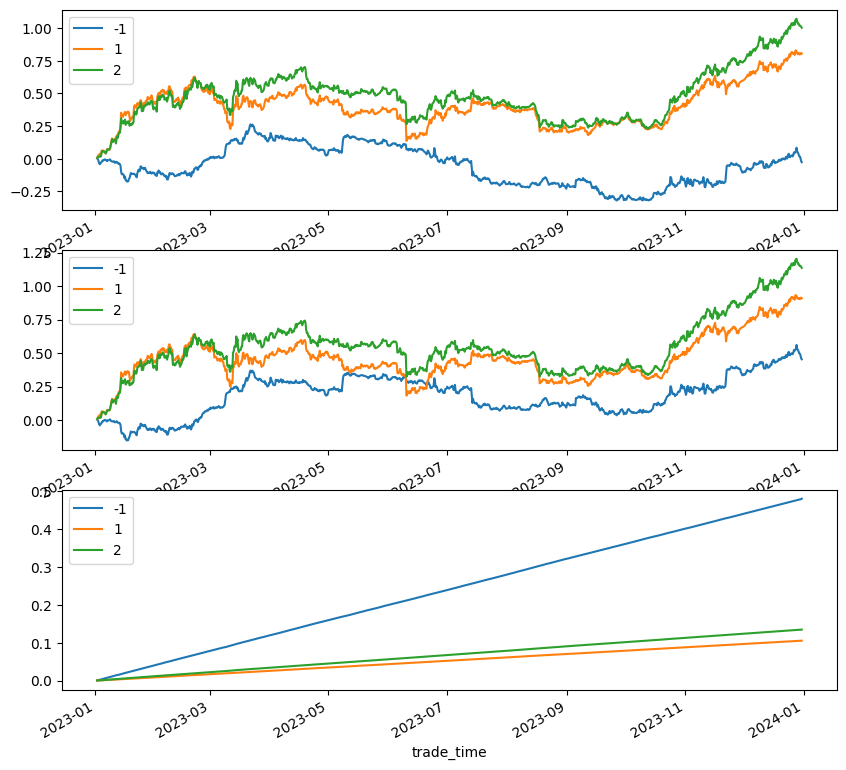

In [186]:
draw(result)

In [11]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour") order by trade_time, instrument
    ''')
for i in range(1, 102):
    try:
        df = sess.run(f'''
            factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
            factor = table(factor.rowNames() as trade_time, factor)
            factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
            factor.rename!(`trade_time`instrument`factor_value)
            factor = select trade_time, instrument, factor_value from factor where factor_value is not null
            select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
        ''')
        print(df)
        result = backtest(df, 2)
        sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
        if abs(sharpe) > 1:
            with open('dynamic_2_grp_2.txt', 'a') as f:
                f.write(f'{i},{sharpe}\n')
        print(sharpe)
    except:
        print("skip ", i)
sess.close()

        trade_time     instrument  factor_value
0       2021-01-01   1000BONKUSDT     -0.496032
1       2021-01-01  1000FLOKIUSDT     -0.496032
2       2021-01-01   1000LUNCUSDT     -0.496032
3       2021-01-01   1000PEPEUSDT     -0.496032
4       2021-01-01   1000RATSUSDT     -0.496032
...            ...            ...           ...
6622807 2024-01-01        YGGUSDT     -0.384921
6622808 2024-01-01        ZECUSDT     -0.202381
6622809 2024-01-01        ZENUSDT      0.019841
6622810 2024-01-01        ZILUSDT      0.019841
6622811 2024-01-01        ZRXUSDT      0.019841

[6622812 rows x 3 columns]
Server response: 'backtest(factor, num) => backtest: grouped = group_factor(combine, num) => group_factor: throw "group ratio > 20%, check!", quantile_ratio => trade_time              grp ratio             ----------------------- --- ----------------- 2021.01.01T08:00:00.000 1   1                 2021.01.02T00:00:00.000 1   0.435897435897436 2021.01.02T00:00:00.000 2   0.435897435897436 2021.0

1.6066169522155576


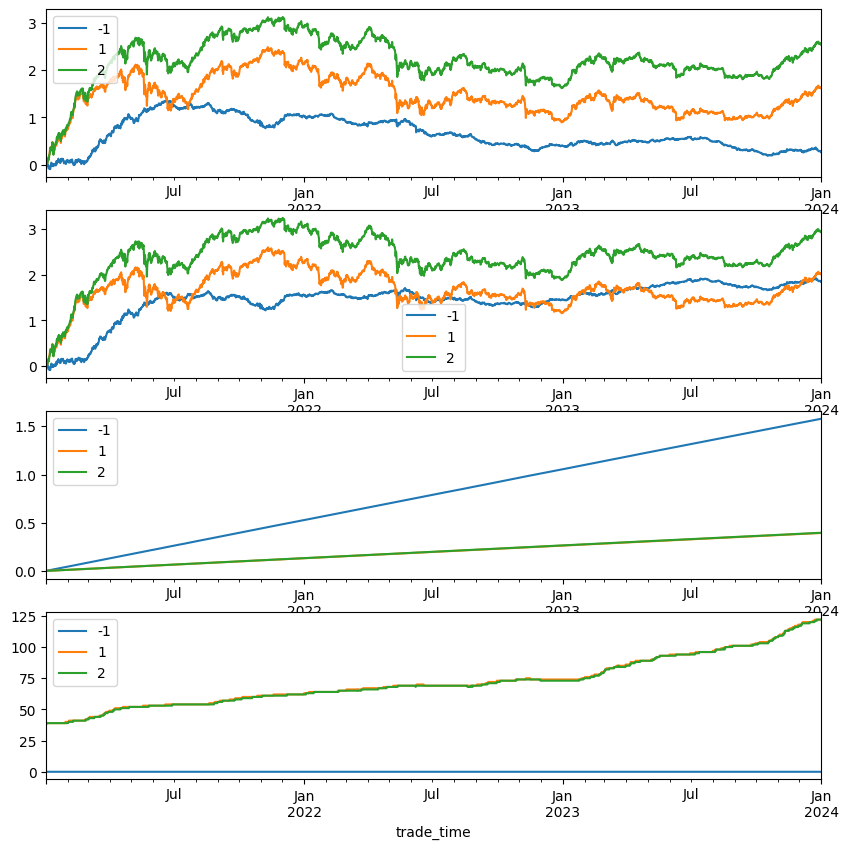

In [19]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour") order by trade_time, instrument
    ''')

i = 30
df = sess.run(f'''
    factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
    factor = table(factor.rowNames() as trade_time, factor)
    factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
    factor.rename!(`trade_time`instrument`factor_value)
    factor = select trade_time, instrument, factor_value from factor where factor_value is not null
    select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
''')
# df['factor_value'] = -df['factor_value']
sess.close()
# df = df[df['trade_time'] >= '20200201']
# print(df)
result = backtest(df, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [2]:
import dolphindb as ddb
import pandas as pd


sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour")
    ''')
lucky = '''2,1.4317617658091235
6,-1.22331333141334
19,1.7492571361873892
30,1.5846507522690674
37,1.0444579127639086
38,2.2345266919595885
54,1.3956501862195263
60,1.0714170696945486'''
tot = None
for line in lucky.split('\n'):
    parts = line.split(',')
    i = parts[0]
    weight = float(parts[1])
    df: pd.DataFrame = sess.run(f'''
        factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
        factor = table(factor.rowNames() as trade_time, factor)
        factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
        factor.rename!(`trade_time`instrument`factor_value)
        factor = select timestamp(trade_time) as trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
        // factor = select trade_time, instrument, factor_value / max(abs(factor_value)) as factor_value from factor context by trade_time
        select * from factor where trade_time >= 2021.01.01 order by trade_time, instrument
    ''')
    df['factor_value'] = df['factor_value'] * weight
    # result = backtest(df, 2)
    # sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
    # print(sharpe)
    if tot is not None:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = pd.merge(tot, df, how='left', on=['trade_time', 'instrument'])
    else:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = df
print(tot)
# print(df)
# result = backtest(df, 2)
# sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
# print(sharpe)
# draw(result)

sess.close()

        trade_time instrument  factor_value_2  factor_value_6  \
0       2021-01-01  1INCHUSDT       -1.770669        2.083382   
1       2021-01-01   AAVEUSDT       -1.177661        1.417770   
2       2021-01-01    ADAUSDT       -0.403767       -0.245699   
3       2021-01-01   ALGOUSDT        0.465980       -1.328918   
4       2021-01-01  ALPHAUSDT       -0.292122        0.012803   
...            ...        ...             ...             ...   
3801186 2024-01-01    YGGUSDT       -1.458017       -1.789922   
3801187 2024-01-01    ZECUSDT       -0.723104       -0.982348   
3801188 2024-01-01    ZENUSDT        1.009122        0.323340   
3801189 2024-01-01    ZILUSDT       -0.280609        1.390606   
3801190 2024-01-01    ZRXUSDT       -0.383473       -0.507317   

         factor_value_19  factor_value_30  factor_value_37  factor_value_38  \
0               1.202553         0.832837         1.925874         1.971413   
1              -1.988298         3.008832        -0.047343   

In [3]:
# df = tot[tot.isna()]
df = tot.fillna(0)
df
# tot[tot['factor_value_19'].isna()]

,trade_time,instrument,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60
0,2021-01-01,1INCHUSDT,-1.770669,2.083382,1.202553,0.832837,1.925874,1.971413,2.540371,1.528198
1,2021-01-01,AAVEUSDT,-1.177661,1.417770,-1.988298,3.008832,-0.047343,1.495969,1.765996,-1.293957
2,2021-01-01,ADAUSDT,-0.403767,-0.245699,2.152387,-0.730468,0.347300,-0.792936,0.908376,1.835952
3,2021-01-01,ALGOUSDT,0.465980,-1.328918,1.840723,-0.533069,-0.705083,-3.264363,-0.225993,-2.802138
4,2021-01-01,ALPHAUSDT,-0.292122,0.012803,1.529059,1.897266,-0.573535,1.169192,1.670947,0.833714
...,...,...,...,...,...,...,...,...,...,...
3801186,2024-01-01,YGGUSDT,-1.458017,-1.789922,1.940017,1.199674,-0.237270,0.625460,-1.357949,-0.091460
3801187,2024-01-01,ZECUSDT,-0.723104,-0.982348,1.292307,-0.555020,-0.777904,1.401643,-0.120976,0.873916
3801188,2024-01-01,ZENUSDT,1.009122,0.323340,1.393368,0.991398,-0.814851,-1.728894,-0.798680,0.127032
3801189,2024-01-01,ZILUSDT,-0.280609,1.390606,-1.822218,0.287687,0.194408,-2.562049,-0.810832,0.115659


1.499662867954214


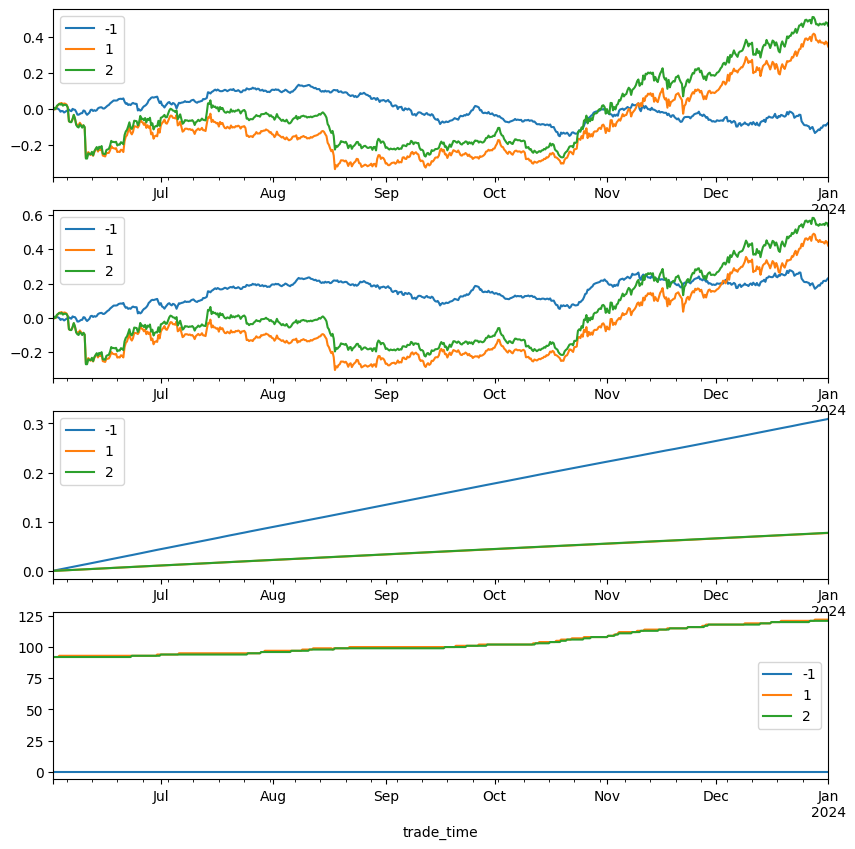

In [8]:
baseline = df.copy()
idx = 2
baseline['factor_value'] = baseline.iloc[:, idx:idx+1].sum(axis=1)
baseline = baseline[['trade_time', 'instrument', 'factor_value']]
baseline = baseline[baseline['trade_time'] > '20230601']
result = backtest(baseline, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [4]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sql = '''
def get_label(instruments) {
    min_time = min(instruments['trade_time'])
    max_time = max(instruments['trade_time'])
    crypto_price = select * from loadTable("dfs://crypto_db", "k_hour") where trade_time >= min_time and trade_time <= temporalAdd(max_time, 2, `d)
    hour_num = 8
    crypto_return = select trade_time, instrument, move(ratios(open) - 1, -1) as ret from crypto_price context by instrument
    crypto_label = select trade_time, instrument, move(mavg(ret, hour_num) / mstd(ret, hour_num), -hour_num) as label from crypto_return context by instrument
    // crypto_label = select trade_time, instrument, move((open / move(open, hour_num) - 1), -hour_num) as ret from crypto_price context by instrument csort trade_time
    crypto_label = select * from crypto_label where trade_time >= min_time and trade_time <= max_time order by trade_time, instrument

    return crypto_label
}

get_label(df)
'''
sess.run("df = table(1000:0,`trade_time`instrument, [TIMESTAMP,SYMBOL])")
sess.run("tableInsert{df}",df[['trade_time', 'instrument']])
df_return = sess.run(sql)
sess.close()
factor_with_label = pd.merge(df, df_return, how='left', on=['trade_time', 'instrument'])
factor_with_label = factor_with_label.dropna()

        trade_time instrument  factor_value_6
0       2021-01-01  1INCHUSDT        2.083382
1       2021-01-01   AAVEUSDT        1.417770
2       2021-01-01    ADAUSDT       -0.245699
3       2021-01-01   ALGOUSDT       -1.328918
4       2021-01-01  ALPHAUSDT        0.012803
...            ...        ...             ...
3801186 2024-01-01    YGGUSDT       -1.789922
3801187 2024-01-01    ZECUSDT       -0.982348
3801188 2024-01-01    ZENUSDT        0.323340
3801189 2024-01-01    ZILUSDT        1.390606
3801190 2024-01-01    ZRXUSDT       -0.507317

[3801128 rows x 3 columns]
1.1197664749236393


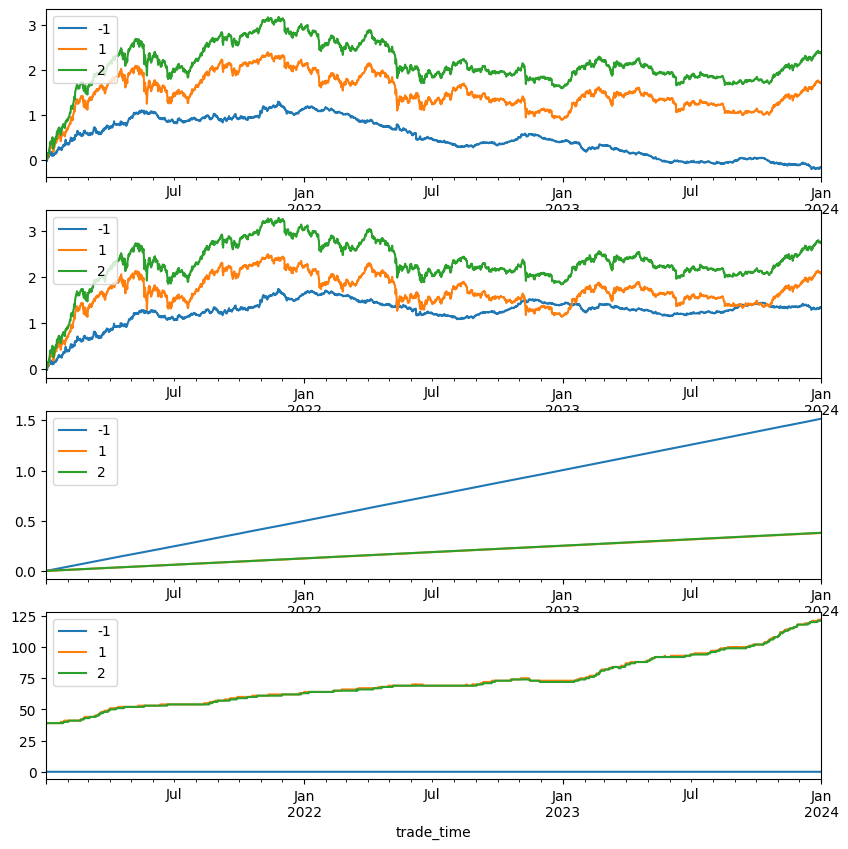

In [76]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df = factor_with_label[['trade_time', 'instrument', 'factor_value_6']]
print(df)
# df['factor_value'] = -df['factor_value']
# print(df)
sess.close()
result = backtest(df, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [138]:
factor_with_label[factor_with_label.columns[2:]].corr()

,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60,ret
factor_value_2,1.000000,-0.065274,0.201825,0.007190,0.036960,0.131577,0.010682,-0.023900,-0.024798
factor_value_6,-0.065274,1.000000,-0.110859,-0.057391,-0.032387,-0.077689,-0.006486,0.025748,0.017509
factor_value_19,0.201825,-0.110859,1.000000,0.112741,0.098518,0.364976,0.144368,-0.056102,-0.078946
factor_value_30,0.007190,-0.057391,0.112741,1.000000,0.140555,0.318614,0.128922,0.091029,-0.044529
factor_value_37,0.036960,-0.032387,0.098518,0.140555,1.000000,0.345661,0.222358,-0.054817,-0.068816
factor_value_38,0.131577,-0.077689,0.364976,0.318614,0.345661,1.000000,0.335743,0.155053,-0.141476
factor_value_54,0.010682,-0.006486,0.144368,0.128922,0.222358,0.335743,1.000000,0.299479,-0.175949
factor_value_60,-0.023900,0.025748,-0.056102,0.091029,-0.054817,0.155053,0.299479,1.000000,-0.066209
ret,-0.024798,0.017509,-0.078946,-0.044529,-0.068816,-0.141476,-0.175949,-0.066209,1.000000


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# 使用MSE作为划分标准训练随机森林模型
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=8, verbose=2)
factors = factor_with_label.columns[2:-1]
factor_with_return_train = factor_with_label[factor_with_label['trade_time']<'20230101']
X_train, X_test, y_train, y_test = train_test_split(factor_with_return_train[factors], factor_with_return_train['label'], test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

# 使用MSE评估模型
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.7min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s


Mean squared error:  0.00012302046874720189


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [86]:
y_pred = rf.predict(X_test)
print(y_pred)
print(y_test)
# mse = mean_squared_error(y_test, y_pred)
# print('Mean squared error: ', mse)

IndexError: list index out of range

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished
/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_7399/1818312206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = -y_pred


3.663957886346548


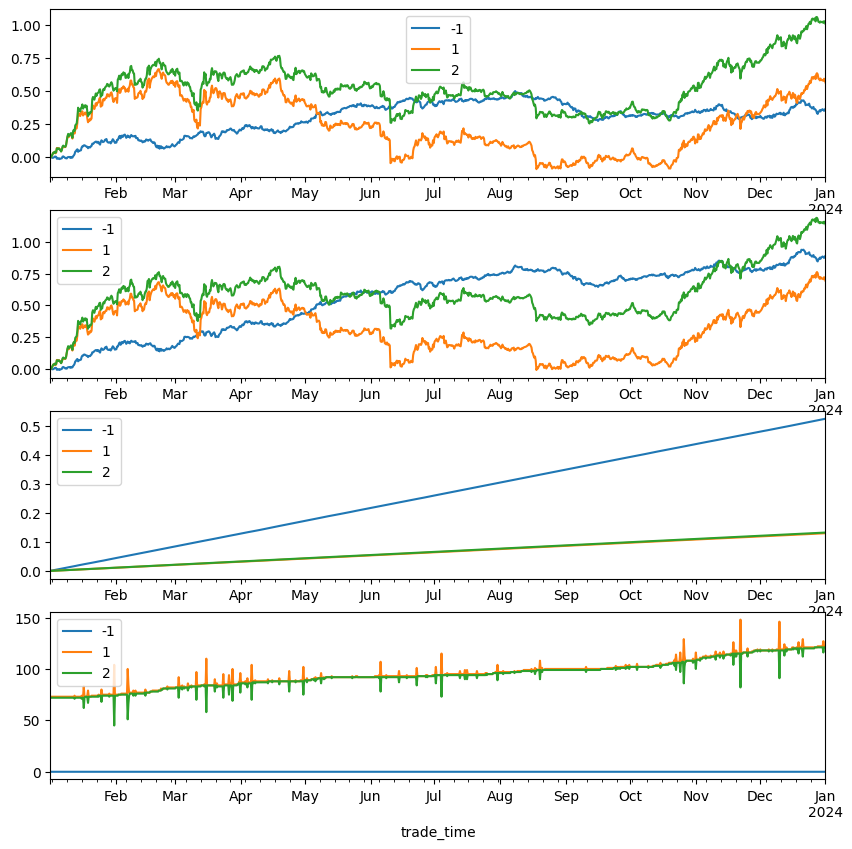

In [59]:
factor_with_return_test = factor_with_label[factor_with_label['trade_time']>='20230101']
y_pred = rf.predict(factor_with_return_test[factors])
combo_factor = factor_with_return_test[['trade_time', 'instrument']]
combo_factor['factor_value'] = -y_pred
combo_factor

result = backtest(combo_factor, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [134]:
factor_with_label

,trade_time,instrument,factor_value_19,label
0,2021-01-01,1INCHUSDT,1.202553,0.336138
1,2021-01-01,AAVEUSDT,-1.988298,0.410967
2,2021-01-01,ADAUSDT,2.152387,0.200281
3,2021-01-01,ALGOUSDT,1.840723,0.392544
4,2021-01-01,ALPHAUSDT,1.529059,0.808269
...,...,...,...,...
3801170,2024-01-01,YGGUSDT,1.940017,-0.015374
3801171,2024-01-01,ZECUSDT,1.292307,-0.364049
3801172,2024-01-01,ZENUSDT,1.393368,-0.336163
3801173,2024-01-01,ZILUSDT,-1.822218,-0.155200


/opt/homebrew/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.2884662142780556
0.1364224185085896


/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_7399/2352671277.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = y_pred


2.6237854618828775


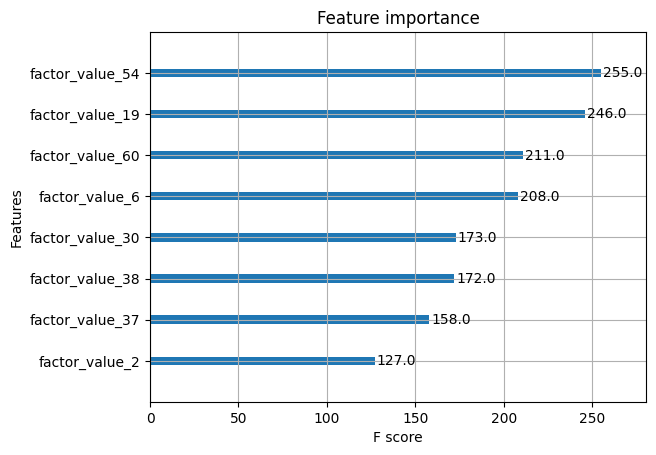

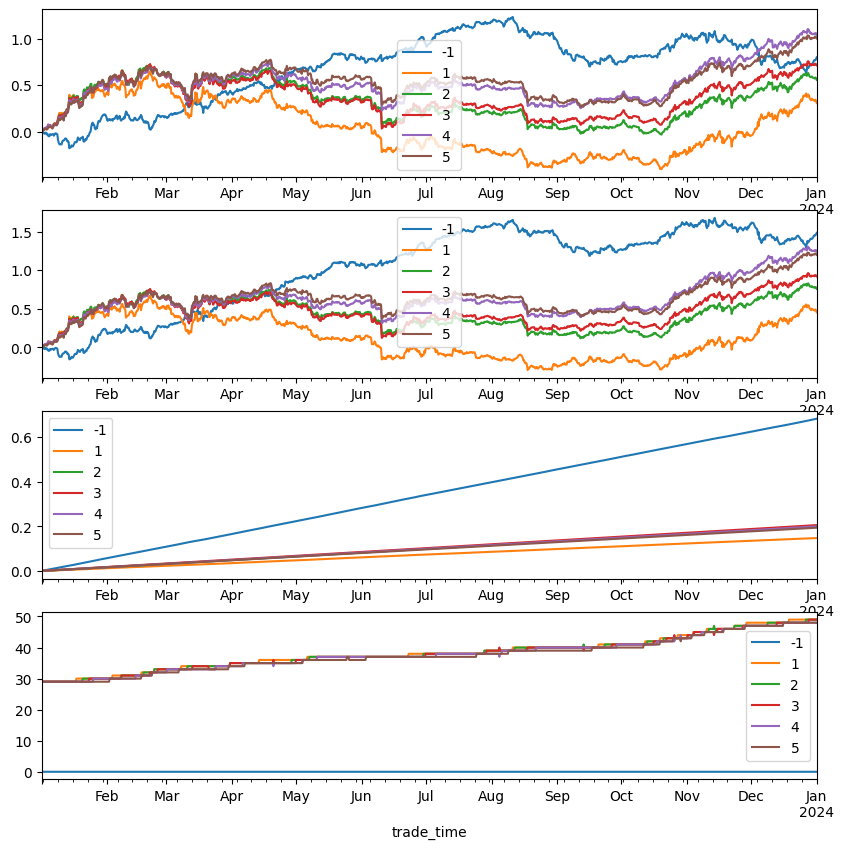

In [144]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 假设我们有一个DataFrame，名为df，其中包含8个特征X1到X8
#我们还有一个目标变量名为y，它可能是你想预测的复合因子。
# X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
# y = df['y']

# 我们将数据集划分为训练集和测试集
factors = factor_with_label.columns[2:-1]
factor_with_return_train = factor_with_label[factor_with_label['trade_time']<'20230101']
X_train, X_test, y_train, y_test = train_test_split(factor_with_return_train[factors], factor_with_return_train['label'], test_size=0.2, random_state=42)


# 将DataFrame转换为DMatrix对象，这是XGBoost的内置数据结构，可以提升性能
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 定义参数
params = {'objective': 'reg:squarederror', 
          'booster': 'gbtree',  
          'eta': 0.03,  
          'max_depth': 5, 
          'subsample': 0.8,  
          'colsample_bytree': 0.6,  
          'silent': 1,  
          'seed': 10}  
num_round = 50  # the number of training iterations

# 训练模型
bst = xgb.train(params, dtrain, num_round)

# 利用测试集进行预测
y_pred = bst.predict(dtest)

# 输出预测结果
# plt.plot(range(len(y_pred)), abs(y_pred - y_test))
# plt.show()
print(y_test.abs().mean())
print(mean_squared_error(y_test, y_pred))

xgb.plot_importance(bst)

/var/folders/h6/c2kcrdsn239c6mbd3hhp4ss80000gn/T/ipykernel_7399/53784722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_factor['factor_value'] = y_pred


3.2743320471023436


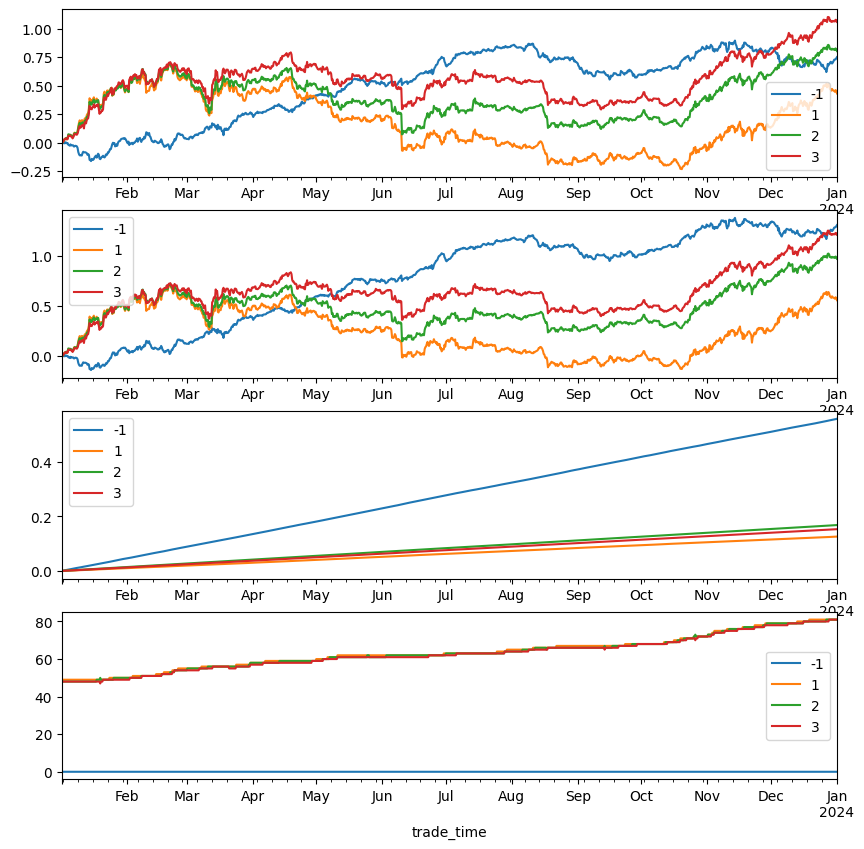

In [145]:
factor_with_return_test = factor_with_label[factor_with_label['trade_time']>='20230101']
x_test = xgb.DMatrix(factor_with_return_test[factors], label=None)
y_pred = bst.predict(x_test)
combo_factor = factor_with_return_test[['trade_time', 'instrument']]
combo_factor['factor_value'] = y_pred
combo_factor

result = backtest(combo_factor, 3)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [9]:
import numpy as np
factor_with_label['trade_time'].unique()
# np.array(factor_with_label[factor_with_label['trade_time']<'20230101'].iloc[:, 2:])

array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ...,
       '2023-12-31T22:00:00.000000000', '2023-12-31T23:00:00.000000000',
       '2024-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

timestep = 24  # 时间步长，就是利用多少时间窗口
batch_size = 1024 * 4  # 批次大小
input_dim = len(factor_with_label.columns) - 3  # 每个步长对应的特征数量

# 形成训练数据，例如12345变成12-3，23-4，34-5
def split_data(data, timestep, input_dim):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep + 1):
        dataX.append(data[index: index + timestep, :-1])
        dataY.append(data[index + timestep - 1][-1])

    dataX = np.array(dataX)
    dataY = np.array(dataY)
    # 获取训练集大小
    train_size = int(np.round(0.6 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, input_dim)
    y_train = dataY[: train_size]

    x_test = dataX[train_size:, :].reshape(-1, timestep, input_dim)
    y_test = dataY[train_size:]

    return [x_train, y_train, x_test, y_test]

# 3.获取训练数据   x_train: 1700,1,4
data = np.array(factor_with_label.iloc[:, 2:])
x_train, y_train, x_test, y_test = split_data(data, timestep, input_dim)

# 4.将数据转为tensor
device = torch.device("cpu")
x_train_tensor = torch.from_numpy(x_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32).to(device)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32).to(device)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size,
                                           True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size,
                                          False)

In [9]:
hidden_dim = 8  # 隐层大小
output_dim = input_dim  # 由于是回归任务，最终输出层大小为1
num_layers = 1  # LSTM的层数


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数
        # input_dim为特征维度，就是每个时间点对应的特征数量，这里为14
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, h_n = self.gru(x)
        
        # print(output.shape) #torch.Size([16, 1, 64]) batch_size,timestep,hidden_dim
        # print(h_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        # print(c_n.shape) torch.Size([3, 16, 64]) num_layers,batch_size,hidden_dim
        batch_size, timestep, hidden_dim = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.bn(output)
        output = self.fc(output)  # 形状为batch_size * timestep, output
        output = output.reshape(timestep, batch_size, -1)
        return self.sigmoid(output[-1])  # 返回最后一个时间片的输出

model = GRU(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络

# loss_function = nn.MSELoss()  # 定义损失函数
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss()   # 计算每个样本的 MSE

    def forward(self, pred, actual):
        # mse = self.mse_loss(pred, actual)  # 计算每个样本的平均 MSE
        combined = torch.cat((pred, actual), dim=1)
        corr = combined.reshape(combined.shape[::-1]).corrcoef()
        corr_good = -(corr.sum(dim=1)[-1] - 1)
        corr_bad = (corr[:corr.shape[0]-1, :corr.shape[0]-1].sum(dim=1)[-1] - 1)
        # print(corr_good, corr_bad)
        loss = corr_good + 0.005 * corr_bad
        # loss = mse + 0.005 * corr_bad
        # loss = corr_good
        return loss  # 最后求平均
    
loss_function = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 定义优化器
epochs = 5
best_loss = 1e10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for idx, data in enumerate(train_bar):
        x_train, y_train = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred: torch.Tensor = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 running_loss / (idx + 1))
    if running_loss / len(train_bar) < best_loss * 0.99:
        best_loss = running_loss / len(train_bar)
    else:
        break

train epoch[5/5] loss:-2.031: 100%|██████████| 557/557 [00:50<00:00, 11.11it/s]


[3.6040860e-06 2.4703089e-05 2.2946527e-04 ... 9.9966866e-01 9.9967319e-01
 9.9967539e-01]
-1.3476566975052247


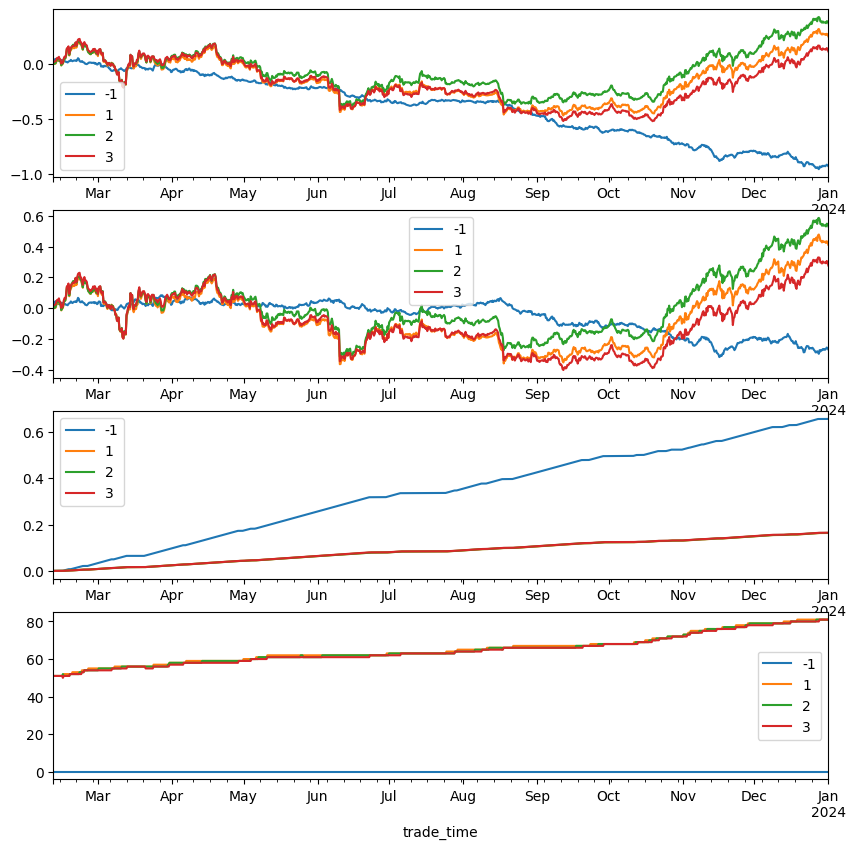

In [10]:
# model.train()
# test_bar = tqdm(test_loader)  # 形成进度条
# y_test_pred_all = np.array([])
# for idx, data in enumerate(test_bar):
#     x_test, y_test = data  # 解包迭代器中的X和Y
#     optimizer.zero_grad()
#     y_test_pred: torch.Tensor = model(x_test)
#     # print(y_test_pred.shape)
#     # total_length += y_test_pred.shape[0]
#     y_test_pred = y_test_pred.mean(dim=1)
#     print(y_test_pred.shape)
#     y_test_pred_all = np.concatenate((y_test_pred_all, y_test_pred.detach().numpy().flatten()))
#     loss = loss_function(y_test_pred, y_test.reshape(-1, 1))
#     loss.backward()
#     optimizer.step()

model.eval()
y_test_pred = model(x_test_tensor)
y_test_pred = y_test_pred.mean(dim=1)
y_test_pred = y_test_pred.detach().numpy().flatten()
y_test_pred_all = y_test_pred
print(y_test_pred_all)
combo_factor = factor_with_label[['trade_time', 'instrument']].iloc[-len(y_test_pred_all):, :]
combo_factor['factor_value'] = y_test_pred_all
# combo_factor

result = backtest(combo_factor, 3)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [141]:
y_test[-1]

-0.02092380576391628

In [143]:
factor_with_label.iloc[-1]

trade_time         2024-01-01 00:00:00
instrument                     ZRXUSDT
factor_value_2               -0.383473
factor_value_6               -0.507317
factor_value_19              -1.330693
factor_value_30              -0.198099
factor_value_37              -1.447098
factor_value_38              -3.603493
factor_value_54              -1.420135
factor_value_60               0.464949
ret                           0.010867
Name: 3801190, dtype: object

In [15]:
y_test_pred.detach().numpy()

array([[-0.0067648 ],
       [-0.02335713],
       [-0.02679934],
       ...,
       [-0.00543373],
       [-0.01420163],
       [-0.02503951]], dtype=float32)